# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite')
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

#  [2] Exploratory Data Analysis

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
final.sort_values('Time',inplace=True)
print(final.head(5))

          Id  ...                                               Text
70688  76882  ...  I bought a few of these after my apartment was...
1146    1245  ...  This was a really good idea and the final prod...
1145    1244  ...  I just received my shipment and could hardly w...
28086  30629  ...  Nothing against the product, but it does bothe...
28087  30630  ...  I love this stuff. It is sugar-free so it does...

[5 rows x 10 columns]


In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

In [10]:
final=final.sample(50000)

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 50000/50000 [00:19<00:00, 2626.69it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [14]:
count_vect = CountVectorizer(min_df=100) 
BOW_50k = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(BOW_50k))
print("the shape of out text BOW vectorizer ",BOW_50k.get_shape())
print("the number of unique words ", BOW_50k.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 2239)
the number of unique words  2239


## [4.3] TF-IDF

In [15]:
tf_idf_vect = TfidfVectorizer(min_df=100)
tfidf_50k=tf_idf_vect.fit_transform(preprocessed_reviews)

print("the type of count vectorizer ",type(tfidf_50k))
print("the shape of out text TFIDF vectorizer ",tfidf_50k.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_50k.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 2239)
the number of unique words including both unigrams and bigrams  2239


## [4.4] Word2Vec

In [16]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [17]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8335044384002686), ('fantastic', 0.8213892579078674), ('terrific', 0.810414731502533), ('good', 0.8003755807876587), ('excellent', 0.7853783965110779), ('wonderful', 0.7596421241760254), ('amazing', 0.7463318109512329), ('perfect', 0.7301979660987854), ('nice', 0.7179259657859802), ('decent', 0.6760915517807007)]
[('greatest', 0.7607515454292297), ('best', 0.7342621088027954), ('closest', 0.6618115305900574), ('experienced', 0.6522546410560608), ('nastiest', 0.6469530463218689), ('superior', 0.6421079039573669), ('tastiest', 0.6296548247337341), ('horrible', 0.6295269727706909), ('disgusting', 0.6182635426521301), ('awful', 0.6081153154373169)]


In [18]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13478
sample words  ['lipton', 'go', 'stix', 'iced', 'green', 'tea', 'mix', 'honey', 'mango', 'pineapple', 'summer', 'like', 'hydrate', 'something', 'extraordinarily', 'sweet', 'nice', 'take', 'away', 'tropical', 'island', 'deserve', 'sorta', 'thought', 'taste', 'anywhere', 'make', 'kind', 'modern', 'convenience', 'blends', 'lifestyle', 'tear', 'top', 'pour', 'bottle', 'chilled', 'water', 'put', 'lid', 'back', 'shake', 'dissolves', 'almost', 'instantly', 'color', 'pleasurable', 'smells', 'soooooo', 'wishes']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [19]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_50k = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_50k.append(sent_vec)
print(len(sent_vectors_50k))
print(len(sent_vectors_50k[0]))

100%|██████████| 50000/50000 [01:29<00:00, 560.87it/s]

50000
50


#### [4.4.1.2] TFIDF weighted W2v

In [20]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [21]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_50k = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_50k.append(sent_vec)
    row += 1

100%|██████████| 50000/50000 [18:05<00:00, 46.08it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

In [22]:
## using upto 10 cluster centers
NumCenters = [2,3,4,5,6,7,8,9,10]

#defining a fucntion to return inertia for every set of cluster center used

def Inertia(NumCenters,data):
  from sklearn.cluster import KMeans
  Inertia=[]
  for i in NumCenters:

      clf = KMeans(n_clusters=i, init='k-means++', verbose=5, n_jobs=-1)
      clf.fit(data)
      kmeans=clf.inertia_
      Inertia.append(kmeans)  
  return Inertia


# plotting The Inertia vs K graph

def PlotElbow(NumCenters,Inertia):
  plt.plot(NumCenters, Inertia)
  plt.xlabel('K-values',size=15)
  plt.ylabel('Inertia',size=15)
  plt.title('Inertia VS K-values Plot\n',size=20)
  plt.grid()
  plt.show()

  '''
Algorithm to find elbow of a graph is taken from the following questionare on Stackoverflow
#######
https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
#######
'''

# finding the Elbow of graph

def ElbowFinder(Inertia):
  import numpy as np
  import numpy.matlib
  nPoints = len(Inertia)
  allCoord = np.vstack((range(nPoints), Inertia)).T
  np.array([range(nPoints), Inertia])
  firstPoint = allCoord[0]
  lineVec = allCoord[-1] - allCoord[0]
  lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
  vecFromFirst = allCoord - firstPoint
  scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
  vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
  vecToLine = vecFromFirst - vecFromFirstParallel
  distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
  return np.argmax(distToLine)






from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Generating word cloud function for a given dataset of str

def ShowWordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()  



# overall function to generate graph and word cloud

def PrintWordcloud(preprocessed_reviews,vectorizer):

# finding inertia and plotting it against different no of cluster
  inertia=Inertia(NumCenters,vectorizer)
  print('Plotting elbow graph')
  PlotElbow(NumCenters,inertia)
  print('\n\n')
# defining kmeans with best K
  from sklearn.cluster import KMeans
  clf= KMeans(n_clusters=ElbowFinder(inertia), n_jobs=-1)
  model=clf.fit(vectorizer)
  labels=model.labels_
# printing all cluters
  unq_labels=np.unique(labels)
  print('All clusters are',unq_labels)
  print("\n")

  corpus = preprocessed_reviews
# list of list containing reviews belonging to each cluster
  ListOfReviewsClusters=[[] for i in unq_labels]
# segregating reviews from each cluster
  for index,word in enumerate(corpus):
    real_label = labels[index]
    ListOfReviewsClusters[real_label].append(word) 
# printing each review cloud
  for i in range(len(list(unq_labels))):
    print('word cloud for cluster', i+1)
    ShowWordcloud(ListOfReviewsClusters[i])
    print('\n\n')
       

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

Plotting elbow graph


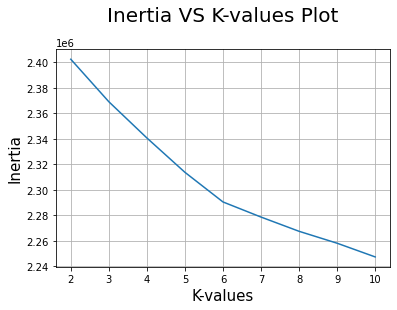




All clusters are [0 1 2 3]


word cloud for cluster 1


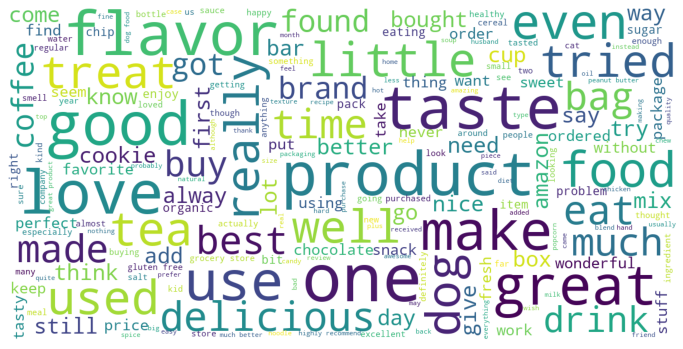




word cloud for cluster 2


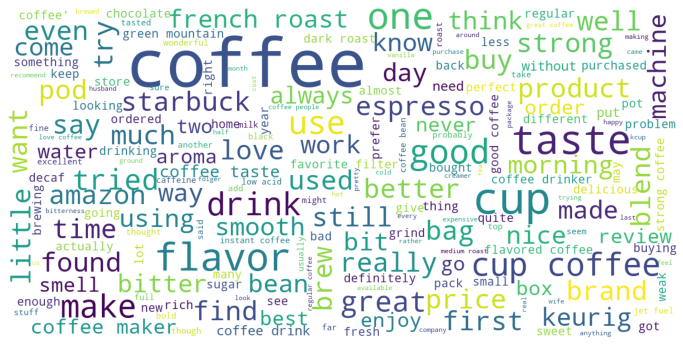




word cloud for cluster 3


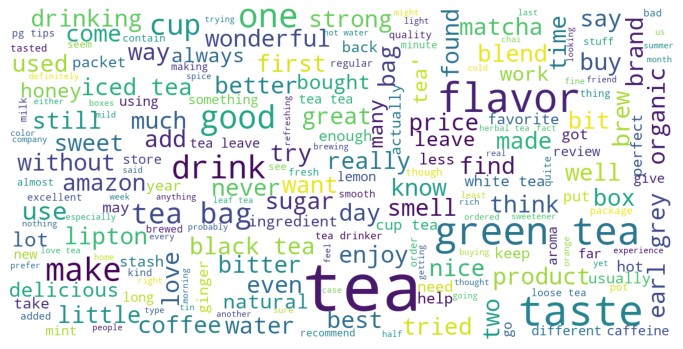




word cloud for cluster 4


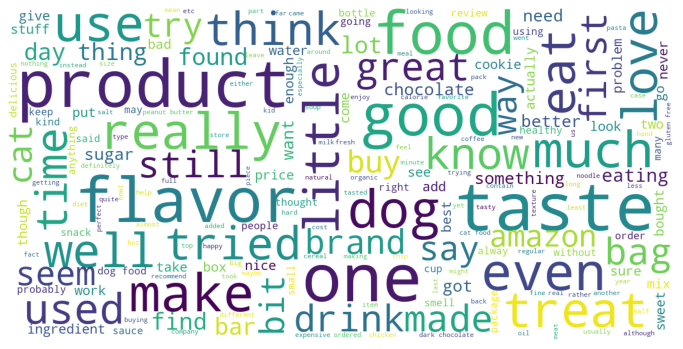

In [23]:
PrintWordcloud(preprocessed_reviews,BOW_50k)

1. word cloud 1 represents good words which constituate good reviews.
2. word cloud 2 represents mainly about coffee and its comparisions.
3. word cloud 3 represents mainly about tea and its comparisions.
4. word cloud 4 seems to cluster mainly noise.

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

Plotting elbow graph


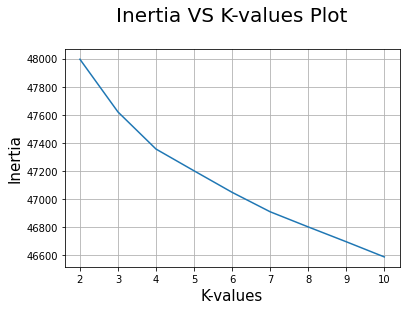




All clusters are [0 1]


word cloud for cluster 1


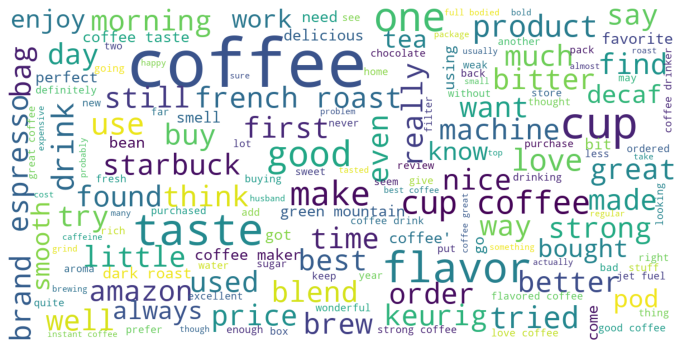




word cloud for cluster 2


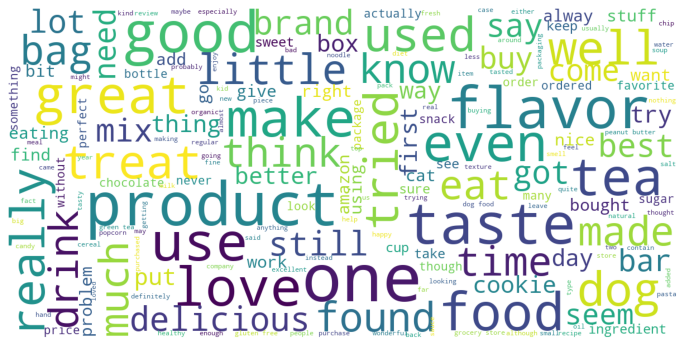

In [24]:
PrintWordcloud(preprocessed_reviews,tfidf_50k)

1. word cloud 1 represents good review about Coffee.
2. word cloud 2 represent in-general positive reviews.


### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

Plotting elbow graph


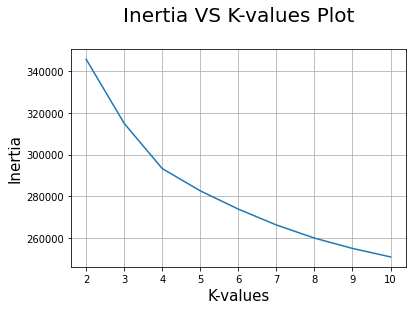




All clusters are [0 1]


word cloud for cluster 1


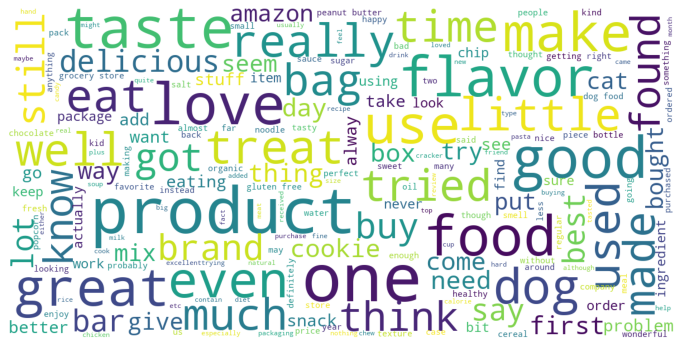




word cloud for cluster 2


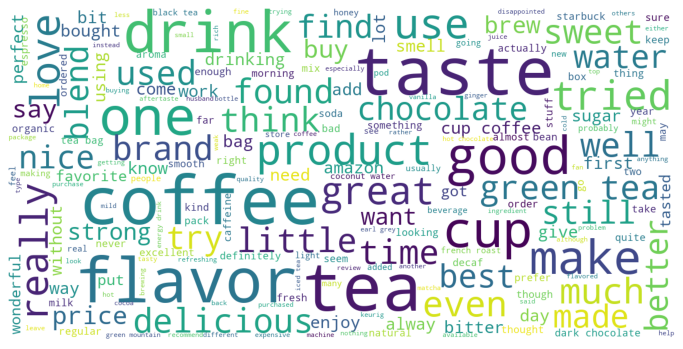

In [25]:
PrintWordcloud(preprocessed_reviews,sent_vectors_50k)

1. word cloud 1 represent in-general positive reviews.
2. word cloud 2 represents good review about Coffee and Tea.



### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

Plotting elbow graph


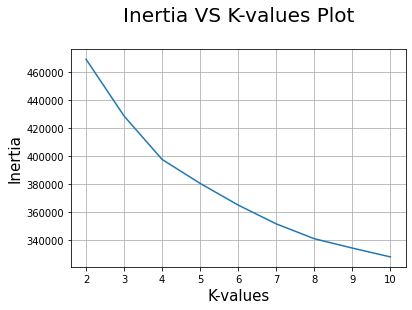




All clusters are [0 1]


word cloud for cluster 1


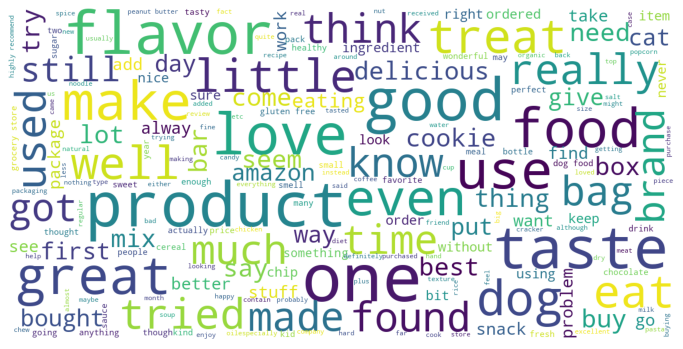




word cloud for cluster 2


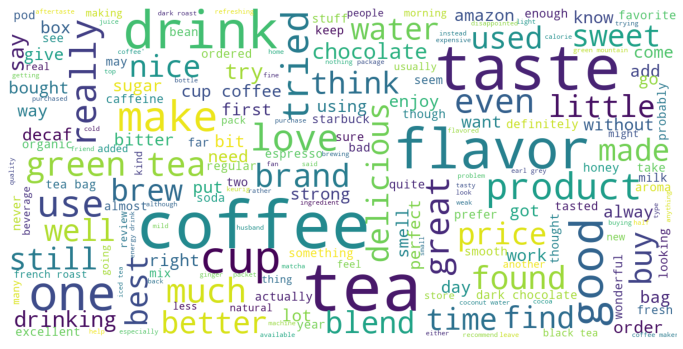

In [27]:
PrintWordcloud(preprocessed_reviews,tfidf_sent_vectors_50k)

same as AVG W2V

1. word cloud 1 represents in general good reviews.
2. word cloud 2 represents good review about Coffee and Tea.


## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [91]:
sent_vect=sent_vectors_50k[:10000]
ppr=preprocessed_reviews[:10000]

In [92]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Generating word cloud function for a given dataset of str

def ShowWordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()  



# overall function to generate graph and word cloud

def PrintWordcloud(preprocessed_reviews,vectorizer,k):

 
  from sklearn.cluster import AgglomerativeClustering
  clf = AgglomerativeClustering(n_clusters=k)
  model=clf.fit(vectorizer)
  labels=model.labels_

  unq_labels=np.unique(labels)
  # print('All clusters are',unq_labels)
  # print("\n")

  corpus = preprocessed_reviews
  ListOfReviewsClusters=[[] for i in unq_labels]

  for index,word in enumerate(corpus):
    real_label = labels[index]
    ListOfReviewsClusters[real_label].append(word) 

  for i in range(len(list(unq_labels))):
    print('word cloud for cluster', i+1)
    ShowWordcloud(ListOfReviewsClusters[i])
    print('\n\n')
       

word cloud for cluster 1


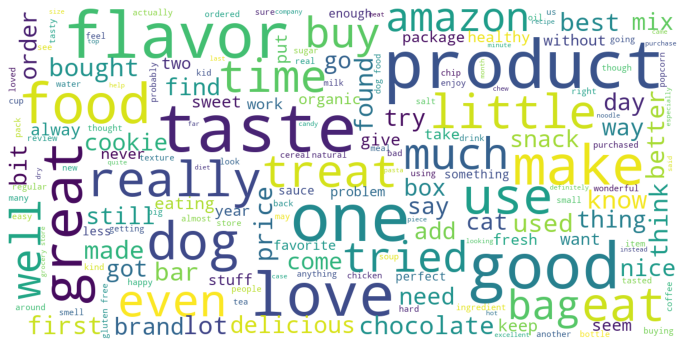




word cloud for cluster 2


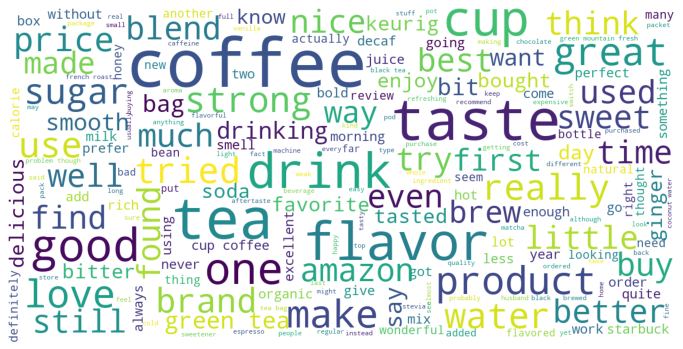

In [93]:
PrintWordcloud(ppr,sent_vect,2)

1. word cloud 1 represents general good reviews.
1. word cloud 1 represents good review about Coffee and tea.


word cloud for cluster 1


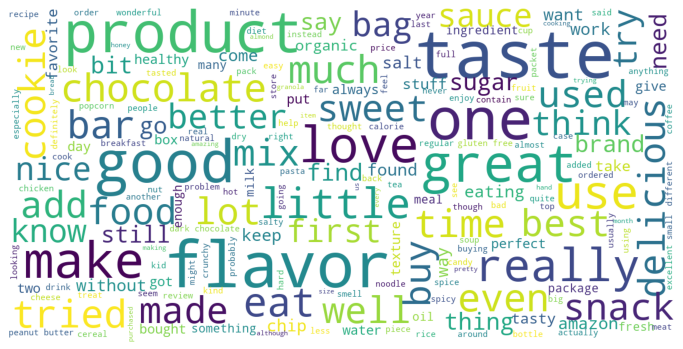




word cloud for cluster 2


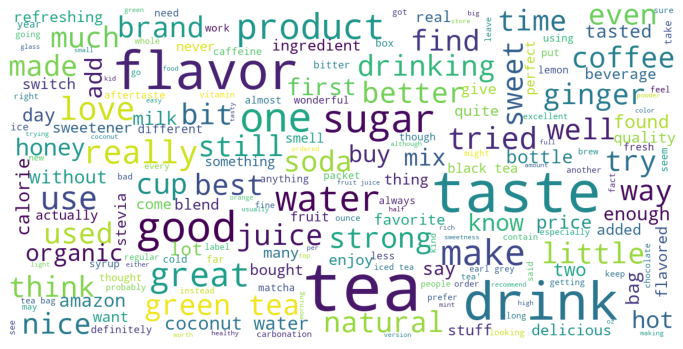




word cloud for cluster 3


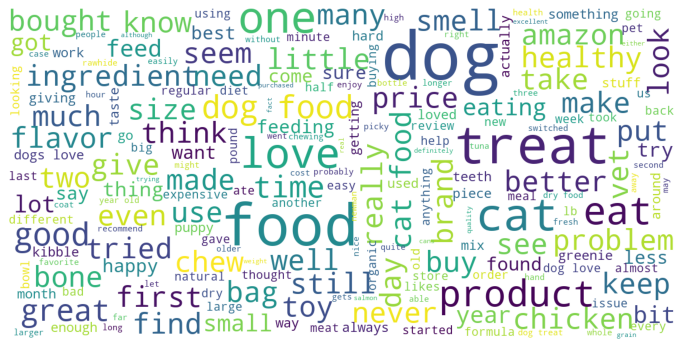




word cloud for cluster 4


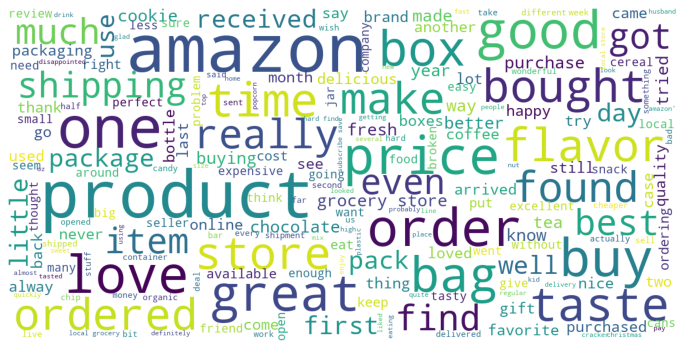




word cloud for cluster 5


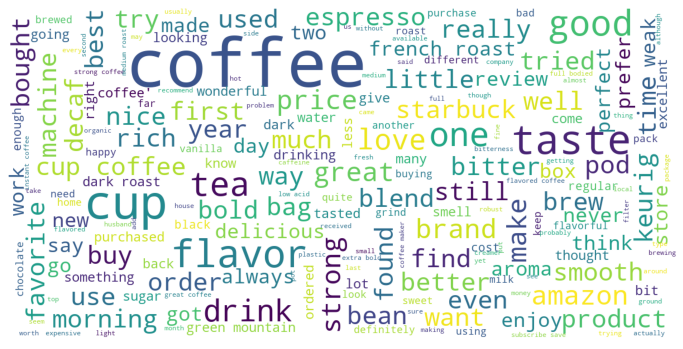

In [94]:
PrintWordcloud(ppr,sent_vect,5)

1. word cloud 1 represents good review about the taste of products.
2. word cloud 2 represents good review about tea.
3. word cloud 3 represents good review about treats and dog/cat food.
4. word cloud 4 represents good review ingeneral.
5. word cloud 5 represents good review about Coffee.





### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [96]:
tfidf_sent_vect=tfidf_sent_vectors_50k[:10000]

word cloud for cluster 1


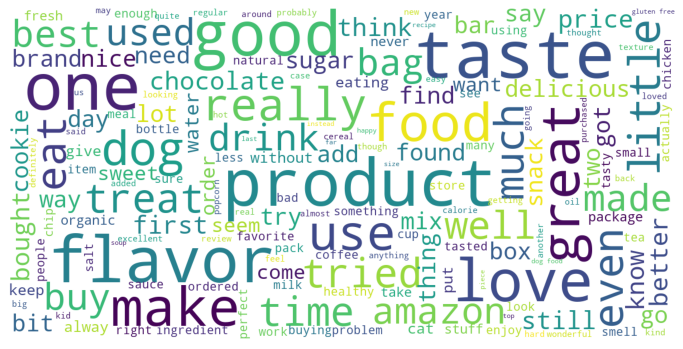




word cloud for cluster 2


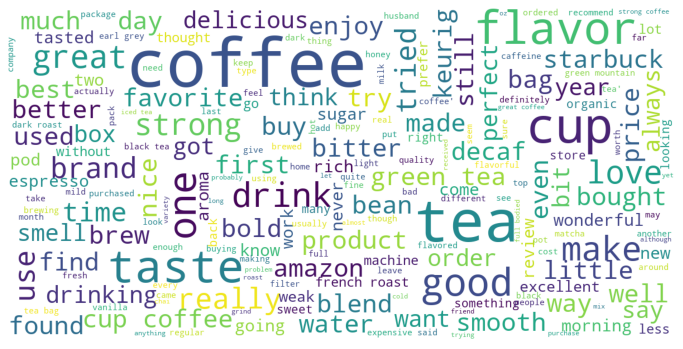

In [97]:
PrintWordcloud(ppr,tfidf_sent_vect,2)

1. word cloud 1 represents good review ingeneral/Noise.
1. word cloud 1 represents good review about Coffee and tea.


word cloud for cluster 1


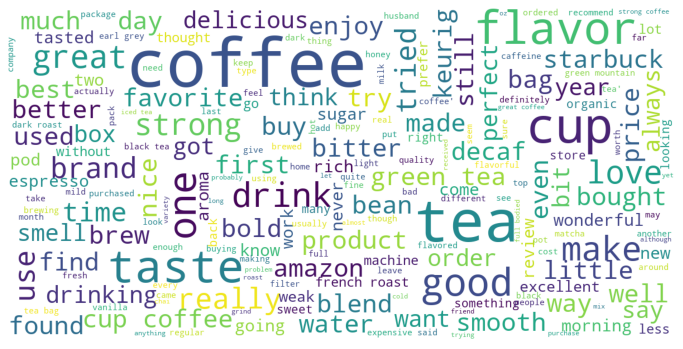




word cloud for cluster 2


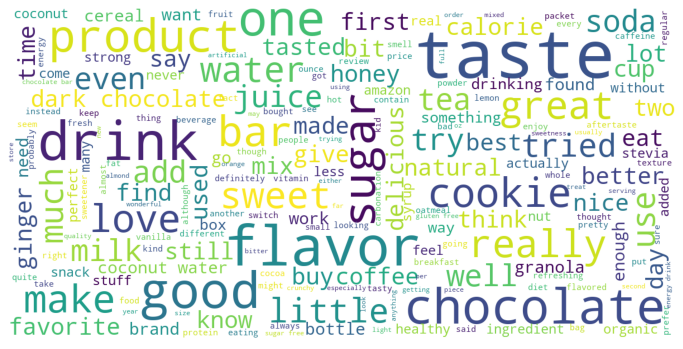




word cloud for cluster 3


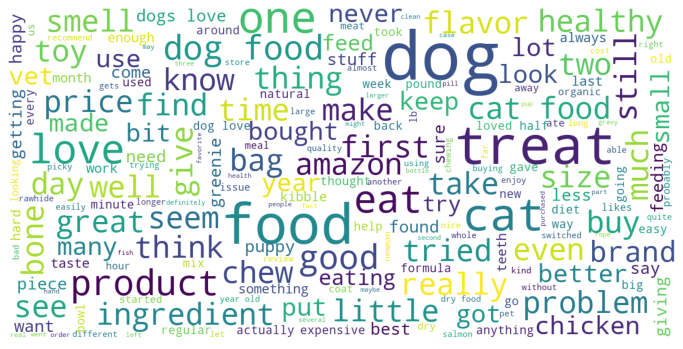




word cloud for cluster 4


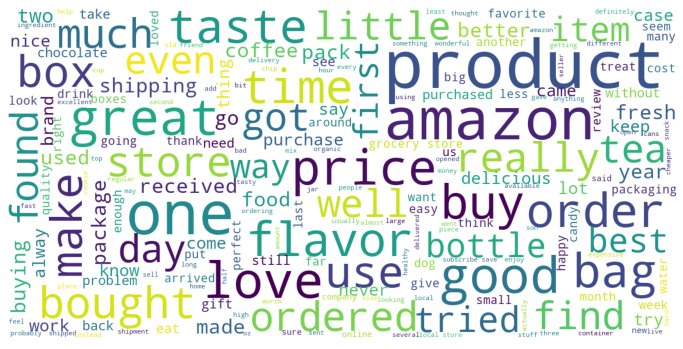




word cloud for cluster 5


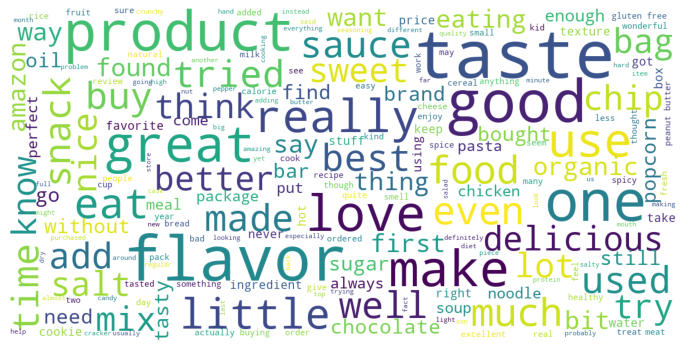

In [98]:
PrintWordcloud(ppr,tfidf_sent_vect,5)

1. word cloud 1 represents good review about Coffee and tea.
2. word cloud 2 represents good review about the taste of products.
3. word cloud 3 represents good review about treats and dog/cat food.
4. word cloud 4 represents good review ingeneral/Noise1.
5. word cloud 5 represents good review ingeneral/Noise2.

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [99]:
## using upto 10 cluster centers
NumCenters = [2,5]

#defining a fucntion to return inertia for every set of cluster center used
'''
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#:~:text=In%20layman's%20terms%2C%20we%20find,and%20select%20that%20as%20epsilon.
'''
def NeighborsDist(data,Min_pt=10):
  from sklearn.neighbors import NearestNeighbors
  nbrs = NearestNeighbors(n_neighbors=Min_pt).fit(data)
  distances, indices = nbrs.kneighbors(data)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1][::-1]
  return distances


# plotting The Inertia vs K graph

def PlotElbow(data):
  plt.plot(data)
  plt.xlabel('Num_pts',size=15)
  plt.ylabel('Distance',size=15)
  plt.title('distance VS Num_pts Plot\n',size=20)
  plt.grid()
  plt.show()

  '''
Algorithm to find elbow of a graph is taken from the following questionare on Stackoverflow
#######
https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
#######
'''

# finding the Elbow of graph

def ElbowFinder(Inertia):
  import numpy as np
  import numpy.matlib
  nPoints = len(Inertia)
  allCoord = np.vstack((range(nPoints), Inertia)).T
  np.array([range(nPoints), Inertia])
  firstPoint = allCoord[0]
  lineVec = allCoord[-1] - allCoord[0]
  lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
  vecFromFirst = allCoord - firstPoint
  scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
  vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
  vecToLine = vecFromFirst - vecFromFirstParallel
  distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
  return Inertia[np.argmax(distToLine)]






from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Generating word cloud function for a given dataset of str

def ShowWordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()  



# overall function to generate graph and word cloud

def PrintWordcloud(preprocessed_reviews,vectorizer,samples=50):

  nbr=NeighborsDist(vectorizer,Min_pt=samples)
  print('Plotting Epsilon graph')
  PlotElbow(nbr)
  print('\n\n')
  print('eps =',ElbowFinder(nbr))
  print('\n\n')


  from sklearn.cluster import DBSCAN

  clf = DBSCAN(min_samples=samples,eps=ElbowFinder(nbr))
  model=clf.fit(vectorizer)
  
  labels=model.labels_

  unq_labels=np.unique(labels)
  print('All clusters are',unq_labels)
  print("\n")

  corpus = preprocessed_reviews
  ListOfReviewsClusters=[[] for i in unq_labels]

  for index,word in enumerate(corpus):
    real_label = labels[index]
    ListOfReviewsClusters[real_label].append(word) 

  for i in range(len(list(unq_labels))):
    print('word cloud for cluster',i-1)
    ShowWordcloud(ListOfReviewsClusters[i])
    print('\n\n')
       

Plotting Epsilon graph


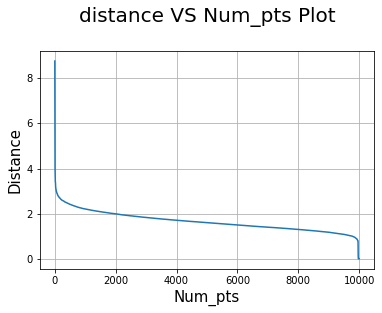




eps = 2.5941881277686805



All clusters are [-1  0]


word cloud for cluster -1


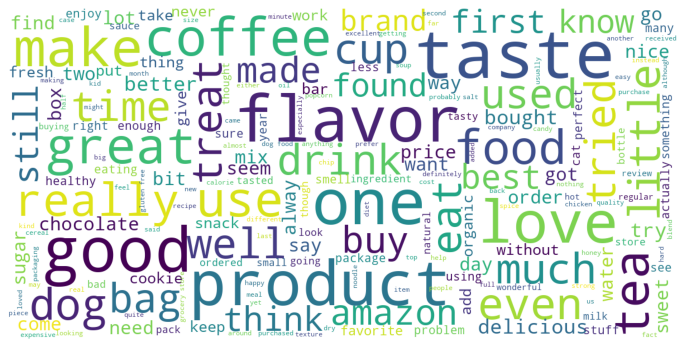




word cloud for cluster 0


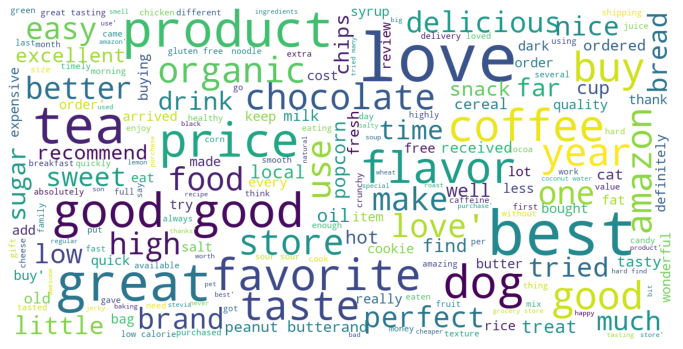

In [100]:
PrintWordcloud(ppr,sent_vect)

1. word cloud -1 represents general Noise.
2. word cloud 2 represents good review about coffe and tea.

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

Plotting Epsilon graph


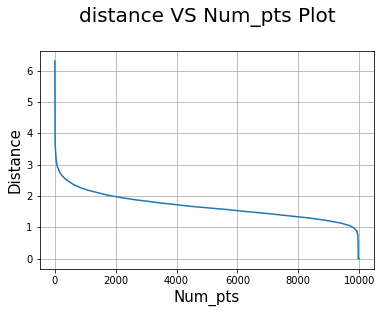




eps = 2.4280391942848922



All clusters are [-1  0]


word cloud for cluster -1


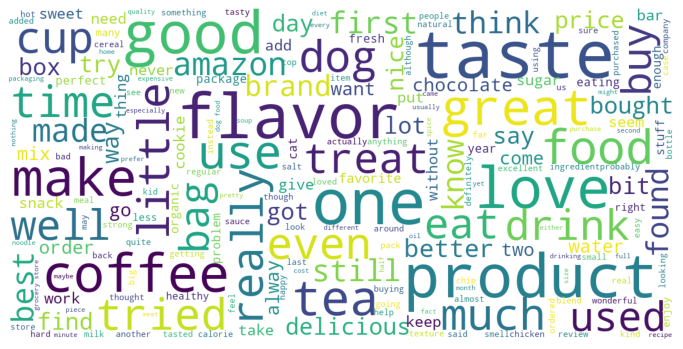




word cloud for cluster 0


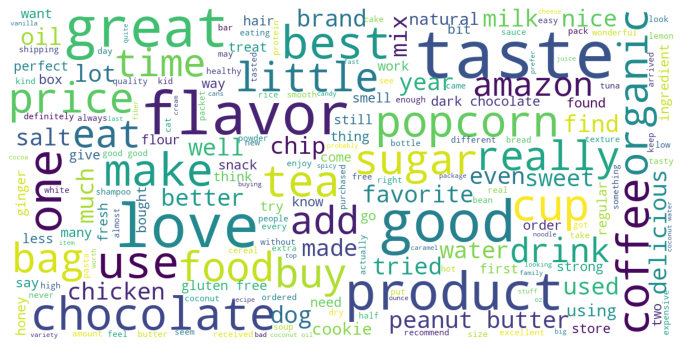

In [101]:
PrintWordcloud(ppr,tfidf_sent_vect)

1. word cloud -1 represents general Noise.
2. word cloud 2 represents good review about coffee and tea.

# [6] Conclusions

In [102]:
from prettytable import PrettyTable
ptable1 = PrettyTable()

vec1 = "BOW"
vec2 = "TFIDF"
vec3 = "AVG-W2V"
vec4 = "TFIDF-W2V"

model1 = 'Kmeans Clustering'
model2 = 'Agglomerative clustering'
model3= 'DBSCAN Clustering'


ptable1.field_names = ["Vectorizer","Model","Clusters"]
ptable1.add_row([vec1,model1,4])
ptable1.add_row([vec2,model1,2])
ptable1.add_row([vec3,model1,2])
ptable1.add_row([vec4,model1,2])
print(ptable1)

ptable2 = PrettyTable()
ptable2.field_names = ["Vectorizer","Model","Optimal_Cluster"]
ptable2.add_row([vec3,model2,2])
ptable2.add_row([vec3,model2,5])
ptable2.add_row([vec4,model2,2])
ptable2.add_row([vec4,model2,5])
print(ptable2)

ptable3 = PrettyTable()
ptable3.field_names = ["Vectorizer","Model","Min-pts","Eps"]
ptable3.add_row([vec3,model3,50,2.594])
ptable3.add_row([vec4,model3,50,2.428])
print(ptable3)

+------------+-------------------+----------+
| Vectorizer |       Model       | Clusters |
+------------+-------------------+----------+
|    BOW     | Kmeans Clustering |    4     |
|   TFIDF    | Kmeans Clustering |    2     |
|  AVG-W2V   | Kmeans Clustering |    2     |
| TFIDF-W2V  | Kmeans Clustering |    2     |
+------------+-------------------+----------+
+------------+--------------------------+-----------------+
| Vectorizer |          Model           | Optimal_Cluster |
+------------+--------------------------+-----------------+
|  AVG-W2V   | Agglomerative clustering |        2        |
|  AVG-W2V   | Agglomerative clustering |        5        |
| TFIDF-W2V  | Agglomerative clustering |        2        |
| TFIDF-W2V  | Agglomerative clustering |        5        |
+------------+--------------------------+-----------------+
+------------+-------------------+---------+-------+
| Vectorizer |       Model       | Min-pts |  Eps  |
+------------+-------------------+---------+--